In [8]:
import numpy as np
import pandas as pd
import sympy
from sympy import *
from operator import mul
from functools import reduce
import mpmath as mp
from mpmath import fac
import functools
from sympy import init_printing
from sympy.core.decorators import _sympifyit, call_highest_priority
from IPython.display import display_latex
init_printing()
import copy
import collections

from sympy.physics.quantum import Commutator, Operator

In [25]:
class LieOperator(Expr):
    '''
    Defined algebra for the Lie operator:
    Addition: Hamiltonian functions get added into a new Lie operator
    Multiplication: Poisson bracket gets applied
    CAUTION: NOT ASSOCIATIVE

    INPUT: Hamiltonian, generalized coordinates and momenta
    '''
    
    
    _op_priority = 11.0

    is_commutative = False
    
#     #Initialize the operator
#     def __init__(self, ham, indep_coords, indep_mom):
#         if S(ham).is_number:
#             raise TypeError('Input has to be a function and not a number.')
#         else:
#             self._ham = ham

#         if not isinstance(indep_coords, list): #create list of coords
#             indep_coords = [indep_coords]
#         if not isinstance(indep_mom, list): #create list of momenta
#             indep_mom = [indep_mom]
            
#         #same number of coordinates and momenta have to be entered
#         assert(len(indep_coords)==len(indep_mom)),'The number of coords and momenta is not the same'
#         self._indep_coords = indep_coords
#         self._indep_mom = indep_mom

        
    def __new__(cls, ham, indep_coords, indep_mom):
        if not isinstance(indep_coords, list): #create list of coords
            indep_coords = [indep_coords]
        if not isinstance(indep_mom, list): #create list of momenta
            indep_mom = [indep_mom]
        
        #same number of coordinates and momenta have to be entered
        assert(len(indep_coords)==len(indep_mom)),'The number of coords and momenta is not the same'
            
        obj = Expr.__new__(cls, ham, indep_coords, indep_mom)
        obj._ham = ham
        obj._indep_coords = indep_coords
        obj._indep_mom = indep_mom
        return obj
    
    
    @property
    def ham(self):
        return self._ham
    
    @ham.setter
    def ham(self, other):
        #Input has to be a function
        assert(not(S(ham.is_number))), 'Input has to be a function and not a number'
        self._ham = self._ham.subs(self.ham, other).doit()
        
    @property
    def indep_coords(self):
        return self._indep_coords
    
    @indep_coords.setter
    def indep_coords(self, other):
        self._indep_coords = other
        
    @property
    def indep_mom(self):
        return self._indep_mom
    
    @indep_mom.setter
    def indep_mom(self, other):
        self._indep_mom = other
        
        
        
    
    #Algebraic properties 

    #Define Addition
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__radd__')
    def __add__(self,other):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return LieOperator(self.ham + other.ham, self.indep_coords,self.indep_mom)

    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__add__')
    def __radd__(self,other):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return LieOperator(self.ham + other.ham, self.indep_coords,self.indep_mom)    
        
    #Define Multiplication
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__rmul__')
    def __mul__(self, other):
        return self.LieOperatorMul(other)
        
        
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__mul__')
    def __rmul__(self,other):
        if S(other).is_number:
            return LieOperator(other*self.ham,self.indep_coords,self.indep_mom)
        elif not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be number or Lie Operator.')
        return other.LieOperatorMul(self)
    
    
    def LieOperatorMul(_ham1, _ham2):
        if not isinstance(_ham2, LieOperator):
            _ham2 = LieOperator(_ham2,_ham1.indep_coords,_ham1.indep_mom) 
        if not collections.Counter(_ham1.indep_coords) == collections.Counter(_ham2.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return _ham1.Poisson(_ham2)
    
    
    #Calcualte Poisson bracket with input function
    def Poisson(self,other):
        _h1 = self.ham
        _h2 = other.ham
        hp = S(0)
        for qi,pi in zip(self.indep_coords, self.indep_mom):
            hp += _h1.diff(qi) * _h2.diff(pi) 
            hp -= _h1.diff(pi) * _h2.diff(qi)
        return LieOperator(hp,self.indep_coords,self.indep_mom)
    
    
    #Exponential Map: Lie Transform
    #Calculate the exponential map of the Lie operator to the input cutoff
    def LieMap(self,other,power):
        s = S(0)
        
        for i in range(power+1):
            s += sympy.Rational(1,factorial(i))*(self.ExpPowerLieBracket(other,i)).ham
        
        return LieOperator(s,self.indep_coords,self.indep_mom) 
    
    
    
    #Successively apply Poisson bracket to input function to the input cutoff
    def ExpPowerLieBracket(self, other, power):
        _op1 = self
        _op2 = other
        
        
        if power > 0:
            hp = _op1*_op2
            
            for s in range(1,power):
                hp = _op1*hp
                
        else:
            if not isinstance(_op2, LieOperator):
                _op2 = LieOperator(_op2, self.indep_coords,self.indep_mom)
            
            hp = _op2
        
        return hp
    
    
    
    #BCH Multiplication
    def BCH(_op1,_op2,n):
        if not isinstance(_op2, LieOperator):
            raise TypeError(_op2, ' has to be a Lie Operator')
        elif not collections.Counter(_op1.indep_coords) == collections.Counter(_op2.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
    
        _s = S(0)  

        for i in range(1,n+1):
            _temp = _op1.translated(i)
            print(_temp)
            _s += _temp
        

        
        temp = _s.replace(Add, lambda *args: _op1.PoissonAddition(_op2,*args))
        temp = temp.ham.replace(Mul, lambda *args: _op1.PoissonMultiplication(_op2,*args))
        
            
        if not isinstance(temp, LieOperator):
            temp = LieOperator(temp,_op1.indep_coords,_op1.indep_mom)
        
#         return LieOperator(_s,_op1.indep_coords,_op1.indep_mom)
        return temp
    
    @staticmethod
    def NP(_n):
        _F = sympy.Matrix(np.zeros((_n+1,_n+1)))
        for i in range(_n+1):
            for j in range(_n+1):
                if (j-i)>=0:
                    _F[i,j] = sympy.Rational(1,int(fac(j-i))) # keep it rational !!!!



        _G = sympy.Matrix(np.zeros((_n+1,_n+1)))
        for i in range(_n+1):
            for j in range(_n+1):
                if (j-i)>=0:
                    if i==j:
                        sigprod = 1
                    else:
                        l = sympy.symbols('s{}:{}'.format(i,j))
                        sigprod = reduce(sympy.Mul,l)
                    _G[i,j] = sympy.Mul(sympy.Rational(1,int(np.math.factorial(j-i))),sigprod, evaluate=False)



        qthpower = sympy.Matrix(np.eye(_n+1))

        FGm1 = sympy.nsimplify(_F*_G - qthpower)

#         FGm1


        summ = 0

        for q in range(1,_n+1):
            qthpower = sympy.nsimplify(sympy.MatMul(qthpower, FGm1, evaluate=False))

            summ += sympy.nsimplify((-1)**(q-1)/q * qthpower)[0,_n] # q-1 because mathematica starts at 1 and not 0, there for sign change

        return sympy.expand(summ)

    
    def translated(self,n):
        l = sympy.symbols('s{}:{}'.format(0,n))
        temp = reduce(functools.partial(sympy.Mul,evaluate=False),[k*k for k in l])
        temp = sympy.expand(sympy.Mul(temp, self.NP(n), evaluate=False),evaluate=False)
        with sympy.evaluate(False):
            ln = sympy.symbols('r{}:{}'.format(0,n), commutative=False)
            for i, s in enumerate(l):
                temp = temp.subs(l[i],ln[i])
            for i in range(n):
                _f = sympy.Symbol('f',commutative=False)
                _g = sympy.Symbol('g',commutative=False)
                temp = temp.subs(ln[i]**3,_g)
                temp = temp.subs(ln[i]**2,_f)
                temp = temp.subs(_g**0,1)

# #             #NEED TO WRITE THE FUNCTIONS TO RELATE NORMAL SYMBOLS TO LIE OPERATORS
#             print('did it happen?')
#             print(_ham1*_ham2)
#             temp = temp.replace(Mul, lambda *args: _ham1.PoissonMultiplication(_ham2,*args))
#             temp = temp.replace(Add, lambda *args: _ham1.PoissonAddition(_ham2,*args))
            
#             if not isinstance(temp, LieOperator):
#                 temp = LieOperator(temp,_ham1.indep_coords,_ham1.indep_mom)
            
        return temp
    
    
    
    def PoissonMultiplication(_op1,_op2,*args):
        _f = sympy.Symbol('f',commutative=False)
        _g = sympy.Symbol('g',commutative=False)
        

        if args[-1] == _f:
            _h = _op1
        elif args[-1] == _g:
            _h = _op2
        else:
            _h = 1
            

        if _f in args or _g in args:
            for op in args[-2::-1]:
                if S(op).is_number:
                    _h = LieOperator(op*_h.ham,_h.indep_coords,_h.indep_mom)
                else:
                    if op == _f:
                        _h = _op1.LieOperatorMul(_h)
                    elif op == _g:
                        _h = _op2.LieOperatorMul(_h)
#                     else:
#                         if not isinstance(op, LieOperator):
#                             op = LieOperator(op,_op1.indep_coords,_op1.indep_mom)
#                         _h = op.LieOperatorMul(_h)
            return _h.ham
        else:
            for arg in args:
                _h *= arg
            
            return _h


        
    
    def PoissonAddition(_op1,_op2,*args):
        _h = 0
        
        _f = sympy.Symbol('f',commutative=False)
        _g = sympy.Symbol('g',commutative=False)
        

        if _f in args or _g in args:
            for op in args:
                if op == _f:
                    _h = _h + _op1.ham
                elif op == _g:
                    _h = _h + _op2.ham
                else:
                    _h = _h + op
        else:
            for arg in args:
                _h = _h + arg
        
        return LieOperator(_h,_op1.indep_coords,_op2.indep_mom)
    

In [26]:
x, p, delta = sympy.symbols('x p d')
H1 = sympy.Function('H1', commutative=True)(x,p)
H2 = sympy.Function('H2', commutative=True)(x,p)
H3 = sympy.Function('H3', commutative=True)(x,p)
W = x**2 + p**2
Z = - sympy.sqrt((1+delta)**2 - p**2)
la = LieOperator(H1,x,p)
lb = LieOperator(H2,x,p)
lc = LieOperator(H3,x,p)
lz = LieOperator(W,x,p)
lw = LieOperator(Z,x,p)

# ma = LieMap(H1,x,p,2,2)
# mb = LieMap(H2,x,p,3,3)
# mc = LieMap(H3,x,p,2,3)

# mw = LieMap(W,x,p,2,2)
# mz = LieMap(Z,x,p,2,2)

In [4]:
t0 = la.BCH(lb,5)

f + g
f*g/2 - g*f/2
f*f*g/12 - f*g*f/6 + f*g*g/12 + g*f*f/12 - g*f*g/6 + g*g*f/12
f*f*g*g/24 - f*g*f*g/12 + g*f*g*f/12 - g*g*f*f/24
-f*f*f*f*g/720 + f*f*f*g*f/180 + f*f*f*g*g/180 - f*f*g*f*f/120 - f*f*g*f*g/120 - f*f*g*g*f/120 + f*f*g*g*g/180 + f*g*f*f*f/180 - f*g*f*f*g/120 + f*g*f*g*f/30 - f*g*f*g*g/120 - f*g*g*f*f/120 - f*g*g*f*g/120 + f*g*g*g*f/180 - f*g*g*g*g/720 - g*f*f*f*f/720 + g*f*f*f*g/180 - g*f*f*g*f/120 - g*f*f*g*g/120 - g*f*g*f*f/120 + g*f*g*f*g/30 - g*f*g*g*f/120 + g*f*g*g*g/180 + g*g*f*f*f/180 - g*g*f*f*g/120 - g*g*f*g*f/120 - g*g*f*g*g/120 + g*g*g*f*f/180 + g*g*g*f*g/180 - g*g*g*g*f/720


f + g
f*g/2 - g*f/2
f*f*g/12 - f*g*f/6 + f*g*g/12 + g*f*f/12 - g*f*g/6 + g*g*f/12


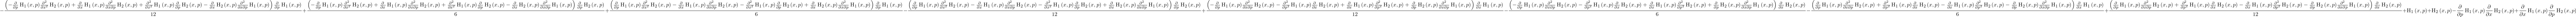

In [28]:
la.BCH(lb,3).ham.doit()